<a href="https://colab.research.google.com/github/pa-blan/CatDog-Classifier/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wandb

In [ ]:
!pip install --upgrade wandb

In [ ]:
!wandb login 467a1c862718fd18ec6dab4f7c13a0d570a610b8

In [ ]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="VGG16")

# Vorbereitung

In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [2]:
!nvidia-smi

Tue Apr  6 19:44:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    39W / 300W |    429MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install keras

# Mount Drive Files (Mount Drive nicht vergessen!)

In [3]:
!ls "/content/drive/My Drive/Colab Notebooks/Udemy Deep Learning/data/PetImages"

cat.jpg  mrschnurr.jpg	PetImages.zip


In [4]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/Udemy Deep Learning/data/PetImages/PetImages.zip" -d "content/"

In [5]:
!ls content/PetImages/

Cat  Dog


Einlesen der Daten

In [6]:
# Einlesen der Daten

import os
import numpy as np
from tqdm import tqdm_notebook as tqdm
from PIL import Image

def read_images(path):
    files = os.listdir(path)
    #Hier wird geprüft ob die Bilder das Format jpg haben
    files = [file for file in files if file[-4:] == ".jpg"]
    
    #Da ich hier aufgrund nur 25 GB Arbeitsspeicher nicht alle Netze trainieren lassen kann muss weniger Bilder einlesen, kann aber auch so funktionieren
    #files = files[:2000]
    
    images = []
    for file in tqdm(files):
        try:
            image = Image.open(os.path.join(path, file))

            # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize
            image = image.resize((224, 224), Image.LANCZOS)

            # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.convert
            image = image.convert("RGB")

            image = np.asarray(image)

            images.append(image)

        except OSError:
            pass
    
    return images
  
#Hier werd die Funktion verwendet
cats = read_images(os.path.join("content", "PetImages", "Cat"))
dogs = read_images(os.path.join("content", "PetImages", "Dog"))
  
dogs = np.asarray(dogs)
cats = np.asarray(cats)

#XDaten hintereinanderhängen und Daten vorbereiten Kommazahlen und Helligkeit von 0 bis 1 Unterstüzt das Netz zum trainieren
#X = np.concatenate([dogs, cats]).astype(np.float32) / 255.
X = np.concatenate([dogs, cats])

# Daten werden in 0 und 1 
y_dogs = np.zeros(len(dogs))
y_cats = np.ones(len(cats))

# y Daten hintereinander anhängen
y = np.concatenate([y_dogs, y_cats])

del dogs, cats, y_dogs, y_cats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Transfer Learning mit VGG 16


In [7]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_v2_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
mobilenet_v2_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

model = Sequential()
model.add(mobilenet_v2_model)

model.add(Flatten(input_shape=(7,7,512)))
# model.add(Dense(1024, activation ="relu"))
model.add(Dense(16, activation ="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(lr= 0.00001), loss= "binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1003536   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,261,537
Trainable params: 1,003,553
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import math

gen = ImageDataGenerator(
    width_shift_range=3, 
    height_shift_range=3, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    vertical_flip=True) 

#Documentation empfiehlt keine batch_size bei generator
training = model.fit(X,y, epochs=50, shuffle=True, validation_split = 0.3)

Epoch 1/50
547/547 [==============================] - 32s 23ms/step - loss: 0.5609 - acc: 0.7175 - val_loss: 0.8397 - val_acc: 0.5243
Epoch 2/50
547/547 [==============================] - 12s 21ms/step - loss: 0.4151 - acc: 0.8101 - val_loss: 0.7612 - val_acc: 0.6049
Epoch 3/50
547/547 [==============================] - 12s 21ms/step - loss: 0.3695 - acc: 0.8359 - val_loss: 0.6986 - val_acc: 0.6411
Epoch 4/50
547/547 [==============================] - 12s 21ms/step - loss: 0.3284 - acc: 0.8615 - val_loss: 0.7349 - val_acc: 0.6196
Epoch 5/50
547/547 [==============================] - 12s 21ms/step - loss: 0.3009 - acc: 0.8813 - val_loss: 0.6576 - val_acc: 0.6655
Epoch 6/50
547/547 [==============================] - 12s 21ms/step - loss: 0.2868 - acc: 0.8839 - val_loss: 0.9672 - val_acc: 0.5245
Epoch 7/50
547/547 [==============================] - 12s 21ms/step - loss: 0.2598 - acc: 0.8983 - val_loss: 0.9089 - val_acc: 0.5595
Epoch 8/50
547/547 [==============================] - 12s 21ms

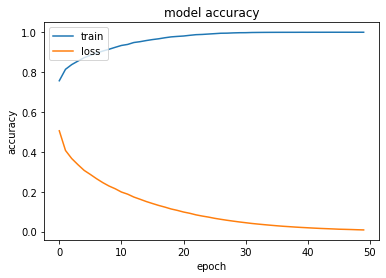

0.003107601867338565
0.01389623135222044
0.9999428391456604


44

In [13]:
import matplotlib.pyplot as plt

plt.plot(training.history["acc"])
#plt.plot(result.history["X_test"])
plt.plot(training.history["loss"])
#plt.plot(training.history["val_loss"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "loss"], loc="upper left")
plt.show()

print(np.var(training.history["acc"]))
print(np.var(training.history["loss"]))
acc_max = max(training.history["acc"])
print(acc_max)
training.history["acc"].index(acc_max)

In [14]:
model.save("TransferlearningVGG16.h5")

In [ ]:
!cp -u TransferlearningVGG16.h5 "drive/My Drive/TransferlearningVGG16.h5"

WandB

In [ ]:
import os
model.save(os.path.join(wandb.run.dir, "TransferlearningVGG16.h5"))

### Schritt 1: Daten einlesen

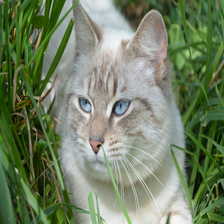

In [ ]:
from PIL import Image
imageg  = Image.open("drive/My Drive/Colab Notebooks/Udemy Deep Learning/data/PetImages/cat.jpg")
image = imageg.resize((224, 224), Image.LANCZOS)
image

### Schritt 2: Daten vorbereiten

In [ ]:
image = np.asarray(image)
print(image.shape)

data = image.reshape(1, 224,224,3)
print(data.shape)

(224, 224, 3)
(1, 224, 224, 3)


### Schritt 3: VGG16 laden, und `X_after_vgg` berechnen

In [ ]:
from keras.applications.vgg16 import VGG16

vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))
X_after_vgg = vgg16_model.predict(data)

### Schritt 4: Unser Modell laden und die Wahrscheinlichkeit für eine Katze berechnen

In [ ]:
from keras.models import load_model

#model = load_model("/content/drive/My Drive/Colab Notebooks/Modelle/TransferlearningVGG16.h5")
print(model.predict(X_after_vgg).astype(np.float32))

[[1.]]
